# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [14]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


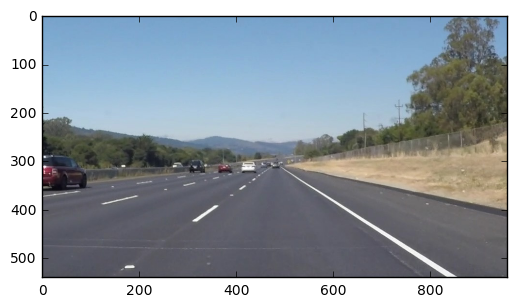

In [15]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [16]:
"""
Road lane line detection pipeline.
"""

import math
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import datetime
import numpy as np
import time
from sklearn.linear_model import RANSACRegressor
from enum import Enum
from collections import deque


class Pipeline:
    """
    Road lane detection pipeline.
    """
    """ Canny detection parameters """
    CANNY_THRESHOLD_LOW = 150
    CANNY_THRESHOLD_HIGH = 250
    CANNY_APERTURE = 9
    """ Hough probabilistic transform parameters """
    """ Distance resolution in pixels of the Hough grid """
    HOUGH_RHO = 1
    """ Angular resolution in radians of the Hough grid """
    HOUGH_THETA = 1 * np.pi / 180
    """ Minimum number of votes (intersections in Hough grid cell). Greatly affects detection quality. """
    HOUGH_THRESHOLD = 15
    """ Minimum number of pixels making up a line. If too large, 
    Note:  
    Smaller minimum length is useful also because some lane line markers can be quite short.
    """
    HOUGH_MIN_LINE_LEN = 4
    """ Maximum gap in pixels between connectable line segments.
    Note: Hough transform will not work as well in images, where there are very strong shadows or colouring differences on the road.
    In intensely textured regions it is not good to have long lines, because in lane detection we use iterative linear regression weighted by line weights.
    Also line coherence filter works better if Hough transform creates smaller lines.
    """
    HOUGH_MAX_LINE_GAP = 6

    UPPER_ROI_HALF_WIDTH_RATIO = 25 / 960

    ROI_HEIGHT_RATIO = 0.55

    def __init__(self, is_debug=False):
        """
        :param is_debug: Is debug mode.
        """
        self.is_debug = is_debug
        self.initialized = False
        self.road = None
        self.current_frame = None
        self.initial_roi = None
        self.width = None
        self.height = None
        self.min_y = None

    def pipeline(self, image):
        """
        Process image in the pipeline.
        :param image: image to be processed.
        :rtype: Annotated processed image.
        """
        if not self.initialized:
            self.init(image)

        self.current_frame = FrameContext(image, debug=False)

        # preprocess image and return filtered gray channel
        hls = self.convert_to_hls(image)
        filtered_gray_channel = self.process_channels(hls)

        self.current_frame[ImageType.EDGE_IMAGE] = edges = self.process_edges(filtered_gray_channel)

        # detect lines from edges
        lines = self.hough_lines(edges)
        self.road.add_lines(lines)

        if self.is_debug:
            line_img = np.zeros((edges.shape[0], edges.shape[1], 3), dtype=np.uint8)
            Display.draw_lines(line_img, lines)
            self.current_frame[ImageType.HOUGH_LINE_IMAGE] = line_img
            self.current_frame[ImageType.ORIGINAL_W_HOUGH_LINE_IMAGE] = ImageUtilities.weighted_img(line_img, image)

        # annotate image with lanes
        lane_img = np.zeros((edges.shape[0], edges.shape[1], 3), dtype=np.uint8)
        Display.draw_lanes(lane_img, self.road, is_debug=False, render_lines=True)
        self.current_frame[ImageType.LANE_IMAGE] = lane_img
        orig_w_lanes = self.current_frame[ImageType.ORIGINAL_W_LANE_IMAGE] = ImageUtilities.weighted_img(lane_img,
                                                                                                         image)
        return orig_w_lanes

    def init(self, image):
        """Pipeline is initialized during processing of the first video frame.
        In the worksheet some images have h 720, w 1280 and in some places h 540 w 960. Thus we need to parametrize this.
        :param image: first image frame
        """
        imshape = image.shape
        if self.is_debug:
            print('image shape', imshape)
        self.width = width = imshape[1]
        self.height = height = imshape[0]
        roi_half_width = Pipeline.UPPER_ROI_HALF_WIDTH_RATIO * width
        ulx, uly = int(width / 2 - roi_half_width * 2), int(height * Pipeline.ROI_HEIGHT_RATIO)
        urx, ury = ulx + roi_half_width * 2, uly
        if self.is_debug:
            print("width ", width, " height ", height, "ulx uly urx uly", ulx, uly, urx, ury)
        self.initial_roi = np.array([[(0, height), (ulx, uly), (urx, ury), (width, height)]], dtype=np.int32)
        self.road = Road(self)
        self.initialized = True

    def convert_to_hls(self, image):
        """
        Preprocessing of the image.
        :param image: image frame
        :return: HLS color space version of image
        """
        # Convert to HLS and blur image
        hls_img = ImageUtilities.convert_to_hls(image)
        self.current_frame[ImageType.HLS_OF_ORIG] = hls_img
        return hls_img

    def process_channels(self, hls_image):
        """
        Samples the image into different color channels and creates a mask to filter image by main lane line colours. 
        Note: For yellow we have two channels so as to avoid adding all the dried grass into the pipeline.
        Note: We also tried to do contrast limited histogram equalization on the HLS lightness channel and then to combine the
        mask with a gray scale image that has been blurred using Gaussian blur and sharpened using unsharp mask, 
        but this did not enhance the detection efforts. Thus confirmed that a bitmask is just enough, as suggested by Kirill Danilyuk.
        
        :param hls_image:  HLS color space version of image
        :return: lane image filter
        """
        light_yellow_lane = ChannelPipeline.light_yellow_lane_channel(hls_image)
        gray_lane = ChannelPipeline.gray_lane_channel(hls_image)
        yellow_lane = ChannelPipeline.yellow_lane_channel(hls_image)
        white_lane = ChannelPipeline.white_lane_channel(hls_image)
        lane_filter = cv2.bitwise_or(white_lane, cv2.bitwise_or(gray_lane,
                                                                cv2.bitwise_or(yellow_lane,
                                                                               light_yellow_lane)))
        if self.is_debug:
            self.current_frame[ImageType.YELLOW_CHANNEL] = yellow_lane
            self.current_frame[ImageType.GRAY_CHANNEL] = gray_lane
            self.current_frame[ImageType.LIGHT_YELLOW_CHANNEL] = light_yellow_lane
            self.current_frame[ImageType.WHITE_CHANNEL] = white_lane
            self.current_frame[ImageType.LANE_MASK] = lane_filter
        return lane_filter

    def process_edges(self, filtered_gray_channel):
        """
        Does edge detection and masks the image using region of interest area.
        :param filtered_gray_channel: 
        :return: 
        """
        edge_filter = Pipeline.canny_channel(filtered_gray_channel)
        return ImageUtilities.region_of_interest(edge_filter, self.initial_roi)

    def hough_lines(self, edges):
        return ImageUtilities.hough_lines(edges,
                                          Pipeline.HOUGH_RHO, Pipeline.HOUGH_THETA,
                                          Pipeline.HOUGH_THRESHOLD,
                                          Pipeline.HOUGH_MIN_LINE_LEN,
                                          Pipeline.HOUGH_MAX_LINE_GAP)

    def canny_channel(channel):
        return ImageUtilities.canny(channel,
                                    Pipeline.CANNY_THRESHOLD_LOW,
                                    Pipeline.CANNY_THRESHOLD_HIGH,
                                    Pipeline.CANNY_APERTURE)


class ChannelPipeline:
    """
    Image color channel pipeline for separating color channels from HLS color space image.
    After the color channel is separated, noise reduction is done using the 'close' morphological transform.
    Note: Tried different morphological transforms like open, and also combinations of dilation, erosion, etc.
    Cross kernel and close-transform turned out to be the best for the morphological filter. In strongly shadowed areas this kind 
    of noise reduction worked very well.
    """
    (hls_yellow, _, _) = cv2.cvtColor(np.uint8([[[0, 255, 255]]]), cv2.COLOR_BGR2HLS)[0][0]
    (hls_light_yellow, _, _) = cv2.cvtColor(np.uint8([[[51, 191, 250]]]), cv2.COLOR_BGR2HLS)[0][0]
    hls_yellow_min = np.array([hls_yellow - 10, 135, 64], np.uint8)
    hls_yellow_max = np.array([hls_yellow + 15, 230, 240], np.uint8)
    hls_light_yellow_min = np.array([hls_light_yellow - 5, 140, 220], np.uint8)
    hls_light_yellow_max = np.array([hls_light_yellow + 5, 170, 255], np.uint8)
    hls_gray_min = np.array([0, 145, 0], np.uint8)  # 0 155 0
    hls_gray_max = np.array([180, 255, 50], np.uint8)  # 180 255 50
    hls_white_min = np.array([0, 220, 0], np.uint8)  # 220
    hls_white_max = np.array([180, 255, 255], np.uint8)
    channel_noise_reduction_kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))

    @staticmethod
    def select_channel(image, num):
        return image[:, :, num]

    @staticmethod
    def channel_to_image(channel):
        return cv2.merge((channel, channel, channel))

    @staticmethod
    def yellow_lane_channel(image):  # morphological_transform(
        return ChannelPipeline._process_channel(image, ChannelPipeline.hls_yellow_min, ChannelPipeline.hls_yellow_max)

    @staticmethod
    def gray_lane_channel(image):
        return ChannelPipeline._process_channel(image, ChannelPipeline.hls_gray_min, ChannelPipeline.hls_gray_max)

    @staticmethod
    def light_yellow_lane_channel(image):
        return ChannelPipeline._process_channel(image, ChannelPipeline.hls_light_yellow_min,
                                                ChannelPipeline.hls_light_yellow_max)

    @staticmethod
    def white_lane_channel(image):
        return ChannelPipeline._process_channel(image, ChannelPipeline.hls_white_min, ChannelPipeline.hls_white_max)

    @staticmethod
    def _process_channel(image, hls_min, hls_max):
        """
        Extract a subset of the image by selecting a subset of its color space. This subset we call a channel.
        :param image: image from which channel will be extracted
        :param hls_min: corner of color cube 
        :param hls_max: opposite corner of color cube
        :return: color channel
        """
        channel = cv2.inRange(image, hls_min, hls_max)
        return ImageUtilities.morphological_transform(channel, ChannelPipeline.channel_noise_reduction_kernel)


def convert_to_2d(arrays):
    """
    Convert 1D array to 2D array 
    :param arrays: 
    :return: 
    """
    return np.atleast_2d(arrays).T



class Road:
    """
    Road detection
    """
    RANSAC_REGRESSOR_RANDOM_SEED = 42
    RANSAC_REGRESSOR_MIN_THRESHOLD = 120
    LINE_TO_VP_Y_DISTANCE = -20
    LINE_TO_VP_DISTANCE = 20
    VALID_VP_AREA_HEIGHT_TO_IMAGE_HEIGHT = 2 / 3
    MAX_VP_X_DEVIATION = 30
    MAX_VP_Y_SHRINKING_DEVIATION = 300
    MAX_VP_Y_GROWING_DEVIATION = 30

    def __init__(self, pipeline):
        """
        Constructor of Road
        :param pipeline: reference to pipeline
        """
        self.processor = pipeline
        self.is_debug = pipeline.is_debug
        self.roi = pipeline.initial_roi
        if self.is_debug:
            print('roi', self.roi)
        self.lane_vanishing_point = None
        self.measured_vanishing_point = None
        self.vanishing_point_buffer = deque(maxlen=Lane.MOVING_AVERAGE_WINDOW)

        self.left_lane = Lane(self)
        self.right_lane = Lane(self, is_right_lane=True)

        self.avg_vp = (0, 0)

    def add_lines(self, raw_lines):
        """
        We are updating road with a new set of raw lines from a new image.
        Detection will be done in several phases.    
        1. Angular filter is applied to the raw lines and too horizontal and too vertical lines are removed.
        2. Vanishing point is detected by RANSAC regression.
        3. Based on the vanishing point fit, lines that do not contribute to the vanishing point are filtered out.
        4. Lines are sorted between lanes and initial fit is done.
        5. Vanishing point defined by the lane lines is calculated.
        6. Calculated vanishing point is used to filter lines again and the lane lines fit is further refined.
        :param raw_lines: detected lines provided by line detection stage
        """
        if raw_lines is not None:
            lines = [Line(raw_line) for raw_line in raw_lines]
            lines = [line for line in lines if self._angular_filter(line)]
            self.measured_vanishing_point, inliner_mask = self.find_vanishing_point(
                lines, self.lane_vanishing_point)
            lines = self.filter_by_measured_vanishing_point(lines, inliner_mask)
            left_lines = self.left_lane.process_lines_init(lines)
            right_lines = self.right_lane.process_lines_init(lines)
            self.lane_vanishing_point = self.calculate_lane_vanishing_point()
            self.left_lane.process_lines_final(
                self.vanishing_point_lines_filter(left_lines), inliner_mask)
            self.right_lane.process_lines_final(
                self.vanishing_point_lines_filter(right_lines), inliner_mask)
            if self.is_debug:
                print('previous lane_vanishing_point', self.lane_vanishing_point)
            self.lane_vanishing_point = self.calculate_lane_vanishing_point()
            if self.is_debug:
                print('lane_vanishing_point', self.lane_vanishing_point)
            self.update_average_vanishing_point(self.lane_vanishing_point)
        else:
            print("No lines were detected!")

    def filter_by_measured_vanishing_point(self, lines, inliner_mask):
        """
        Filters by measured vanishing point. Only consider filter if the vanishing point is in the upper 2/3 of the image.
        If it is not, then vanishing point detection is misbehaving and there is no sense in reducing number of lines further.
        :param lines: 
        :param inliner_mask: 
        :return: 
        """
        # if self.measured_vanishing_point[1] < self.processor.height * Road.VALID_VP_AREA_HEIGHT_TO_IMAGE_HEIGHT:
        filtered_lines = [line for (line, is_inline) in zip(lines, inliner_mask) if is_inline]
        if self.is_debug:
            print('filtered ', len(lines) - len(filtered_lines))
        return filtered_lines
        # else:
        #    print('Cannot use detected vanishing point for filtering')
        #    return lines

    def calculate_lane_vanishing_point(self):
        a1, b1 = self.left_lane.slope, self.left_lane.intercept
        a2, b2 = self.right_lane.slope, self.right_lane.intercept
        y = (a1 * b2 - a2 * b1) / (a1 - a2)
        x = -(b1 - b2) / (a1 - a2)
        if self.is_debug:
            print('calculated vanishing point', x, y)
        return int(x), int(y)

    def find_vanishing_point(self, lines, lane_vanishing_point):
        """
        We will search for road vanishing point and return the vanishing point along with
        the points that were used by the detection.
        :param lines: lines 
        :param lane_vanishing_point: lane vanishing point 
        :return: detected vanishing point, inlier point mask
        """
        vanishing_point, inliner_mask = self.detect_vanishing_point(lines)
        if lane_vanishing_point is not None and self.is_debug:
            sqr_dist = np.sqrt(np.sum(np.square(np.subtract(vanishing_point, lane_vanishing_point))))
            print('distance between road and texture fitted vanishing point', sqr_dist)
        if self.is_debug:
            removed_lines = [line for (line, is_inline) in zip(lines, inliner_mask) if not is_inline]
            [print("rejecting outlier line ", line.coords) for line in removed_lines]
            print('measured vanishing point', self.measured_vanishing_point)
        return vanishing_point, inliner_mask

    def detect_vanishing_point(self, lines):
        """
        We calculate vanishing point based o=in the Hough space of the detected lines.
        RANSAC regression is used to find the dominant vanishing point in the remaining detected lines.
        This RANSAC regressor uses Least Squares regressor by default, but with a L1 loss function.
        NOTE: residual_threshold turned out to be a very important parameter. By setting it at such a
        large value, RANSAC was able to explore a larger solution space.
        :param lines:
        :return:
        """
        slopes = np.array([l.slope for l in lines])
        lengths = np.array([l.length for l in lines])
        intercepts = np.array([l.intercept for l in lines])
        if self.is_debug:
            t0 = time.time()
        rnd = np.random.RandomState(Road.RANSAC_REGRESSOR_RANDOM_SEED)
        X, y = convert_to_2d(slopes), intercepts
        if self.is_debug:
            print('line number before vanishing point detection', len(lines))
            print("vanishing point detection X,y array", X.shape, y.shape)
        model = RANSACRegressor(random_state=rnd, residual_threshold=Road.RANSAC_REGRESSOR_MIN_THRESHOLD)
        model.fit(X, y, sample_weight=lengths)
        if self.is_debug:
            print(model)
        inlier_mask = model.inlier_mask_
        outlier_mask = np.logical_not(inlier_mask)
        vanishing_point = (int(-model.estimator_.coef_[0]), int(model.estimator_.intercept_))
        if self.is_debug:
            elapsed_time = time.time() - t0
            min_x, max_x = min(X), max(X)
            line_X = np.arange(min_x, max_x)
            line_y = model.predict(line_X)
            plt.figure(1, figsize=(12, 9))
            plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.', label='Inliers')
            plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='.', label='Outliers')
            plt.plot(line_X, line_y, color='cornflowerblue', linestyle='-',
                     linewidth=2, label='%s (fit time: %.2fs)' % ('ransac', elapsed_time))
            plt.legend(loc='upper right')
            print('line detected vanishing_point ', vanishing_point)
            plt.show()
        return vanishing_point, inlier_mask

    def vanishing_point_lines_filter(self, lines):
        return [line for line in lines if self.vanishing_point_line_filter(line)]

    def vanishing_point_line_filter(self, line):
        """
        Filter lines by the 
        :param line: 
        :return: 
        """
        x, y = self.vanishing_point_selector()
        distance = abs(x * line.slope - y + line.intercept) / math.sqrt(1 + line.slope * line.slope)
        if self.is_debug:
            print('line y1 y2', line.y1, line.y2, 'vp', y)
        is_close = line.y1 > y - Road.LINE_TO_VP_Y_DISTANCE and distance < Road.LINE_TO_VP_DISTANCE
        if not is_close and self.is_debug:
            print("rejecting too distant line", line.coords, "distance", distance, "vanishing point", x, y)
        return is_close

    def vanishing_point_selector(self):
        """
        Empirically found out that if the lane line based vanishing point is above the measured vanishing point,
        or reverse, the one above the other, is the correct one. This works, because if there is a lot of texture, its 
        details tend to be visible near the car.
        """
        has_lane_vp = self.lane_vanishing_point is not None
        if has_lane_vp and self.lane_vanishing_point[1] < self.measured_vanishing_point[1]:
            return self.lane_vanishing_point
        else:
            return self.measured_vanishing_point

    def preprocess_lines(self, raw_lines):
        if self.is_debug:
            print('preprocess lines', len(raw_lines))
        return [l for l in raw_lines if self._angular_filter(l)]

    def _angular_filter(self, line):
        correct = not line.is_too_horizontal() and not line.is_too_vertical()
        if self.is_debug and not correct:
            print("line is too horizontal", line.coords, line.slope)
        return correct

    def update_average_vanishing_point(self, new_val):
        self.avg_vp = Road._update_average_array(self.vanishing_point_buffer, Lane.MOVING_AVERAGE_WINDOW,
                                           self.avg_vp, Road.MAX_VP_X_DEVIATION, Road.MAX_VP_Y_SHRINKING_DEVIATION,
                                           Road.MAX_VP_Y_GROWING_DEVIATION, new_val)
        return self.avg_vp

    @staticmethod
    def _update_average_array(queue, max_num, avg, max_x_deviation, max_y_shrinking_deviation, max_y_growing_deviation,
                             new_val):
        """
        Update moving average of a fixed length queue
        :param queue: fixed length queue
        :param max_num: maximum number of elements in the queue
        :param avg: average
        :param max_x_deviation: maximum deviation from the previous value in the x-axis, that would cause the new value to be rejected
        :param max_y_shrinking_deviation: same as above, but for y-axis and for reduction in value
        :param max_y_growing_deviation: same as above, but for y-axis and for growth in value
        :param new_val: new value to be added to the average
        :return: 
        """
        num = len(queue)
        new_avg = new_val

        if num > 0:
            previous_vp = queue[-1]
            not_updatable_x = abs(previous_vp[0] - new_val[0]) > max_x_deviation
            not_updatable_y = (new_val[1] - previous_vp[1]) > max_y_growing_deviation or (previous_vp[1] - new_val[
                1]) > max_y_shrinking_deviation
            if not_updatable_y or not_updatable_x:
                return avg
            if num == max_num:
                first_sample = queue.popleft()
                new_avg_x = (avg[0] * num + new_val[0] - first_sample[0]) / num
                new_avg_y = (avg[1] * num + new_val[1] - first_sample[1]) / num
                new_avg = (new_avg_x, new_avg_y)
            if num < max_num:
                new_avg_x = (avg[0] * num + new_val[0]) / (num + 1)
                new_avg_y = (avg[1] * num + new_val[1]) / (num + 1)
                new_avg = (new_avg_x, new_avg_y)
        queue.append(new_val)
        return new_avg


class Lane:
    """
    Road lane
    It runs a moving average of lane values with a fixed window
    """
    MAX_LINE_ANGLE_TO_LANE_IN = 0.4
    MAX_LINE_ANGLE_TO_LANE_OUT = 0.28
    MAX_DISTANCE_TO_LANE_FROM_ROAD = 30
    MAX_DISTANCE_TO_LANE_TO_ROAD = 15  # 15
    MOVING_AVERAGE_WINDOW = 20
    MAX_X2_DEVIATION = 200

    def __init__(self, road, is_right_lane=False):
        """
        Initialises Lane object and sets default values
        :param road: road
        :param is_right_lane: is right lane 
        """
        self.road = road
        self.is_right_lane = is_right_lane
        self.is_debug = road.is_debug
        self.image_height = road.processor.height
        self.lines = []
        self.slope = 0
        self.intercept = 0
        self.max_y = 0
        self.x2_buffer = deque(maxlen=Lane.MOVING_AVERAGE_WINDOW)
        self.avg_x2 = 0

    def process_lines_init(self, lines):
        """
        Initial processing of lines and coalescing them into a lane line.
        1. Lines are filtered according to the vanishing point.
        2.  1. If lines remain:
                1. fit them.
                2. apply lane coherence filter (filter lines that are not coherent with the lane)
            2. If no lines remain, set the previous slope and intercept parameters. 
        :param lines: lines
        :return: filtered lines 
        """
        self.lines = [l for l in lines if self._right_lane_selector_filter(l)]
        if self.is_debug:
            print('process lines', len(self.lines))
        if len(self.lines) > 0:
            self.slope, self.intercept = self.fit_lines(self.lines)
            self.update_x2(self.current_x2)
            if self.is_debug:
                print("second pass")
            self.lines = [l for l in self.lines if self._second_pass_filter(l)]
        else:
            print("no lanes")
        return self.lines

    def process_lines_final(self, lines, vanishing_point):
        """ 
        Final line processing phase.
            1. Fit lines to lane.
            2. Apply coherence and distance filter.
            3. Add slope and intercept to the buffer.
        :param lines: 
        :param vanishing_point: 
        :return: 
        """
        if len(lines) > 0:
            self.slope, self.intercept = self.fit_lines(lines)
            if self.is_debug:
                print("third pass")
            self.lines = [l for l in lines if self._second_pass_filter(l)]
            self.slope, self.intercept = self.fit_lines(lines)
            self.update_x2(self.current_x2, replace_last=True)
        return self.lines

    def fit_lines(self, lines):
        """
        Least squares fitting the detected lines to lanes.
        If we just were to fit line centroids, orientation information would be lost.
        Thus we fit the start- and end-points of lines.
        :param lines: 
        :return: 
        """
        self.max_y = max(l.max_y for l in lines)
        self.min_y = min(l.min_y for l in lines)
        x1s = np.array([l.x1 for l in lines])
        x2s = np.array([l.x2 for l in lines])
        y1s = np.array([l.y1 for l in lines])
        y2s = np.array([l.y2 for l in lines])
        xs = np.append(x1s, x2s)
        ys = np.append(y1s, y2s)
        slopes = np.array([l.slope for l in lines])
        lengths = np.array([l.length for l in lines])
        intercepts = np.array([l.intercept for l in lines])

        weights = np.append(lengths, lengths)
        total_weight = np.sum(weights)

        avg_x = np.average(xs, weights=weights)
        avg_y = np.average(ys, weights=weights)

        dx = xs - avg_x
        dy = ys - avg_y
        dx2_avg = np.average(np.square(dx), weights=weights)
        dxy_avg = np.average(np.multiply(dx, dy), weights=weights)
        avg_slope = dxy_avg / dx2_avg
        avg_intercept = avg_y - avg_x * avg_slope
        if self.is_debug:
            print('xs.shape', xs.shape)
            print("slopes", slopes)
            print("lengths", lengths)
            print("intercepts", intercepts)
            print('weights', weights.shape)
            chi = np.sum(weights * (ys - (avg_intercept + avg_slope * xs)) ** 2)
            cov_00 = (1.0 / total_weight) * (1.0 + avg_x ** 2 / dx2_avg)
            cov_11 = 1.0 / (total_weight * dx2_avg)
            cov_01 = -avg_x / (total_weight * dx2_avg)
            print("chi", chi, "slope cov", cov_00, " s ", cov_01, "intercept cov", cov_11)
            print("avg slope", avg_slope, "avg_intercept", avg_intercept)
        return avg_slope, avg_intercept

    @property
    def y1(self):
        return int(self.avg_line().y1 - Road.LINE_TO_VP_Y_DISTANCE)

    @property
    def current_y1(self):
        return int(self.road.lane_vanishing_point[1]) - Road.LINE_TO_VP_Y_DISTANCE

    @property
    def x1(self):
        y1 = self.y1
        line = self.avg_line()
        x1 = y1 / line.slope - line.intercept / line.slope
        if math.isnan(x1):
            print("y1 slope causes NaN", self.y1, self.intercept, self.slope)
            x1 = 0
        return int(x1)

    @property
    def current_x1(self):
        if self.slope == 0:
            return 0
        x1 = (self.y1 - self.intercept) / self.slope
        if math.isnan(x1):
            print("y1 slope causes NaN", self.y1, self.intercept, self.slope)
            return 0
        return int(x1)

    @property
    def y2(self):
        return int(self.image_height)

    @property
    def x2(self):
        return int(self.avg_x2)

    @property
    def current_x2(self):
        if self.slope == 0:
            return 0
        x2 = (self.y2 - self.intercept) / self.slope
        if math.isnan(x2):
            print("y2 slope causes NaN", self.y1, self.intercept, self.slope)
            return 0
        return int(x2)

    def avg_line(self):
        vp = self.road.avg_vp
        return Line([[vp[0], vp[1], self.x2, self.y2]])

    @property
    def coords(self):
        return self.x1, self.y1, self.x2, self.y2

    def update_x2(self, new_val, replace_last=False):
        self.avg_x2 = Lane._update_average(self.x2_buffer, Lane.MOVING_AVERAGE_WINDOW,
                                           self.avg_x2, Lane.MAX_X2_DEVIATION,
                                           new_val, replace_last=replace_last)
        return self.avg_x2

    @staticmethod
    def _update_average(queue, max_num, avg, max_deviation, new_val, replace_last=False):
        """
        Update moving average of a fixed length queue
        :param queue: fixed length queue
        :param max_num: maximum number of elements in the queue
        :param avg: average
        :param max_deviation: maximum deviation from the previous value, that would cause the new value to be rejected
        :param new_val: new value to be added to the average
        :return: 
        """
        num = len(queue)
        new_avg = new_val
        if num > 0:
            is_updatable = max_deviation > int(abs(queue[-1] - new_val))
            if not is_updatable:
                return avg
            if replace_last:
                last_value = queue.pop()
                new_avg = (avg * num  - last_value + new_val) / num
            elif num == max_num:
                first_sample = queue.popleft()
                new_avg = (avg * num + new_val - first_sample) / num
            elif num < max_num:
                new_avg = (avg * num + new_val) / (num + 1)
        queue.append(new_val)
        return new_avg

    def _second_pass_filter(self, line):
        return self._coherence_filter(line) and self._distance_filter(line)

    def _coherence_filter(self, line):
        """ Filters lines by their angle in relation to the lane. 
            We look at how the line comes into the lane and comes out of it. As highly textured areas tend to move the detected viewpoint
            downwards, we need to have filter conditions, that would work against this.
        """
        diff = self.slope - line.slope
        to_lane_direction = (diff > 0 and not self.is_right_lane) or diff < 0
        diff = abs(diff)
        if to_lane_direction:
            is_coherent = diff < Lane.MAX_LINE_ANGLE_TO_LANE_OUT
        else:
            is_coherent = diff < Lane.MAX_LINE_ANGLE_TO_LANE_IN
        if not is_coherent and self.is_debug:
            print("Rejecting non-coherent line", line.coords, "angular difference", abs(self.slope - line.slope))
        return is_coherent

    def _right_lane_selector_filter(self, line):
        """ Decides by the vanishing point if a line belongs to the lane. """
        vp = self.road.vanishing_point_selector()
        vp_x = vp[0]
        use_vp = vp[1] < self.road.processor.height * Road.VALID_VP_AREA_HEIGHT_TO_IMAGE_HEIGHT
        if not use_vp:
            print('vanishing point too low!', vp)
        if use_vp:
            if self.is_right_lane:
                return vp_x > line.intercept
            else:
                return vp_x <= line.intercept
        elif (self.is_right_lane and line.has_positive_slope()) \
                or (not self.is_right_lane and not line.has_positive_slope()):
            return True
        return False

    def _distance_filter(self, line):
        """ 
        Filters out lines that are too far from the lane. 
        Distance is calculated according to formula d = (b + a*x - y)/sqrt(1 + a^2) 
        Because lines between lanes are better candidates for removal, we can be more aggressive at removing those.   
        We can be more aggressive in removing lines that are on the road between lane lines!
        """
        distance = (line.center_x * self.slope - line.center_y + self.intercept) / math.sqrt(
            1 + self.slope * self.slope)
        line_on_left = distance < 0
        distance = abs(distance)
        if self.is_right_lane:
            if line_on_left:
                is_close = distance < Lane.MAX_DISTANCE_TO_LANE_FROM_ROAD
            else:
                is_close = distance < Lane.MAX_DISTANCE_TO_LANE_TO_ROAD
        else:
            if line_on_left:
                is_close = distance < Lane.MAX_DISTANCE_TO_LANE_TO_ROAD
            else:
                is_close = distance < Lane.MAX_DISTANCE_TO_LANE_FROM_ROAD
        if self.is_debug and not is_close:
            print("Rejecting too distant line", line.coords, "distance", distance)
        return is_close

    def __str__(self):
        return str(self.coords)


class Line:
    """
    Line object
    """
    MIN_DX = 0.001
    TOO_HORIZONTAL_LINE_SLOPE = 0.4
    TOO_VERTICAL_LINE_SLOPE = 6  # 5.67  # around 80 degrees

    def __init__(self, line):
        self.x1, self.y1, self.x2, self.y2 = line[0]
        dy = self.y2 - self.y1
        dx = self.x2 - self.x1
        if abs(dx) < Line.MIN_DX:  # to avoid division with zero or too large slopes
            dx = math.copysign(Line.MIN_DX, dx)
        # angle between y axis and line
        self._slope = dy / dx  # to avoid zero division sinusoid is much more comfortable than tangens
        self._intercept = (self.x2 * self.y1 - self.x1 * self.y2) / dx

    def is_too_horizontal(self):
        return abs(self.slope) < Line.TOO_HORIZONTAL_LINE_SLOPE

    def is_too_vertical(self):
        return abs(self.slope) > Line.TOO_VERTICAL_LINE_SLOPE

    def has_positive_slope(self):
        return self.slope >= 0

    @property
    def slope(self):
        return self._slope

    @property
    def intercept(self):
        return self._intercept

    @property
    def length(self):
        return math.hypot(self.x2 - self.x1, self.y2 - self.y1)

    @property
    def max_y(self):
        if self.y2 > self.y1:
            return self.y2
        return self.y1

    @property
    def min_y(self):
        if self.y2 < self.y1:
            return self.y2
        return self.y1

    @property
    def center_x(self):
        return (self.x1 + self.x2) / 2

    @property
    def center_y(self):
        return (self.y1 + self.y2) / 2

    @property
    def coords(self):
        return self.x1, self.y1, self.x2, self.y2

    def __str__(self):
        return str(self.coords)


class ImageUtilities:
    """
    Methods for processing images
    """

    @staticmethod
    def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
        """
        `img` is the output of the hough_lines(), An image with lines drawn on it.
        Should be a blank image (all black) with lines drawn on it.

        `initial_img` should be the image before any processing.

        The result image is computed as follows:

        initial_img * α + img * β + λ
        NOTE: initial_img and img must be the same shape!
        """
        return cv2.addWeighted(initial_img, α, img, β, λ)

    @staticmethod
    def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
        """
        `img` should be the output of a Canny transform.
        rho - distance resolution in pixels of the Hough grid
        theta - angular resolution in radians of the Hough grid
        threshold - minimum number of votes (intersections in Hough grid cell)
        min_line_len - minimum number of pixels making up a line
        max_line_gap - maximum gap in pixels between connectable line segments        
        Returns an image with hough lines drawn.
        """
        lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                                maxLineGap=max_line_gap)
        return lines

    @staticmethod
    def morphological_transform(channel, kernel):
        return cv2.morphologyEx(channel, cv2.MORPH_CLOSE, kernel)  # MORPH_CLOSE

    @staticmethod
    def convert_to_hls(img):
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    @staticmethod
    def canny(img, low_threshold, high_threshold, aperture=3):
        """Applies the Canny transform"""
        return cv2.Canny(img, low_threshold, high_threshold, aperture)

    @staticmethod
    def region_of_interest(img, vertices):
        """
        Applies an image mask.

        Only keeps the region of the image defined by the polygon
        formed from `vertices`. The rest of the image is set to black.
        """
        # defining a blank mask to start with
        mask = np.zeros_like(img)

        # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255

        # filling pixels inside the polygon defined by "vertices" with the fill color
        cv2.fillPoly(mask, vertices, ignore_mask_color)

        # returning the image only where mask pixels are nonzero
        masked_image = cv2.bitwise_and(img, mask)
        return masked_image


class Display:
    """
    For displaying pipeline images and annotating them
    """

    @staticmethod
    def draw_lanes(img, road, color_line=(0, 255, 0), color_lane=(255, 0, 0), lane_thickness=10, line_thickness=2,
                   measured_vp_color=(0, 255, 255), lane_vp_color=(255, 0, 255), circle_radius=6,
                   is_debug=False, render_lines=False):
        if is_debug:
            print('left', road.left_lane)
            print('right', road.right_lane)

        def draw_lines(lines, color, thickness):
            if is_debug:
                print('drawing', len(lines))
            if lines is not None:
                for line in lines:
                    x1, y1, x2, y2 = line.coords
                    cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                if is_debug:
                    print(road.measured_vanishing_point)
            else:
                print("No lines were detected!")

        draw_lines([road.right_lane], color_lane, lane_thickness)
        draw_lines([road.left_lane], color_lane, lane_thickness)
        if render_lines and is_debug:
            draw_lines(road.right_lane.lines, (0, 0, 255), line_thickness)
            draw_lines(road.left_lane.lines, color_line, line_thickness)
        if is_debug:
            print('right lines', len(road.right_lane.lines))
            print('left lines', len(road.left_lane.lines))
            cv2.circle(img, road.lane_vanishing_point, circle_radius, lane_vp_color, -1)
            cv2.circle(img, road.measured_vanishing_point, circle_radius, measured_vp_color, 2)

    @staticmethod
    def draw_lines(img, lines, color=(0, 255, 0), thickness=2, is_debug=False):
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)
        else:
            print("No lines were detected!")


class ImageType(Enum):
    RESULT = -1
    ORIGINAL = 1
    HLS_OF_ORIG = 2
    HLS_BLURRED = 3
    WHITE_CHANNEL = 4
    GRAY_CHANNEL = 5
    YELLOW_CHANNEL = 6
    LIGHT_YELLOW_CHANNEL = 7
    LANE_MASK = 8
    GRAY_IMAGE = 9
    CLAHE_GRAY_IMAGE = 10
    FILTERED_GRAY_IMAGE = 11
    GRAY_MASKED_IMAGE = 12
    EDGE_IMAGE = 13
    HOUGH_LINE_IMAGE = 14
    ORIGINAL_W_HOUGH_LINE_IMAGE = 15
    LANE_IMAGE = 16
    ORIGINAL_W_LANE_IMAGE = 17


class FrameContext(dict):
    """
    Holder of various processing information of a single frame.
    Useful for tracking and visualization of the processing pipeline
    """

    def __init__(self, original_image, debug=False):
        super(FrameContext, self).__init__()
        self.debug = debug  # if false, intermediate artefacts will not be saved
        self.images = dict()
        if debug:
            self.images[ImageType.ORIGINAL] = original_image

    def __setitem__(self, key, val):
        if self.is_debug or ImageType.RESULT == key:
            super(FrameContext, self).__setitem__(key, val)

    @property
    def original(self):
        if self.__contains__(ImageType.ORIGINAL):
            return self.get(ImageType.ORIGINAL)

    @property
    def result(self):
        if self.__contains__(ImageType.RESULT):
            return self.get(ImageType.RESULT)

    @property
    def is_debug(self):
        return self.debug


def is_image(file_name):
    return file_name.endswith('.jpg')


def log_processed_image(image, file_name, process_time, file_suffix='', folder=''):
    if file_suffix != '':
        file_suffix += '-'
    if folder != '':
        folder += '/'
    save_file_name = file_suffix + file_name.replace('.jpg', '') + process_time + '.jpg'
    print('saving snapshot file: ' + save_file_name)
    mpimg.imsave(folder + save_file_name, image)


def process_image(source_name, out_folder):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    pipe = Pipeline(is_debug=False)

    def pipeline(image):
        time_start = datetime.datetime.now().strftime("-%B-%d-%I-%M%p")
        try:
            return pipe.pipeline(image)
        except Exception as ex:
            log_processed_image(image, source_name, time_start, file_suffix='error', folder=out_folder)
            print(ex)
            raise ex

    return lambda image: pipeline(image)


## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

saving snapshot file: challengeYellowLane-May-25-08-42PM.jpg


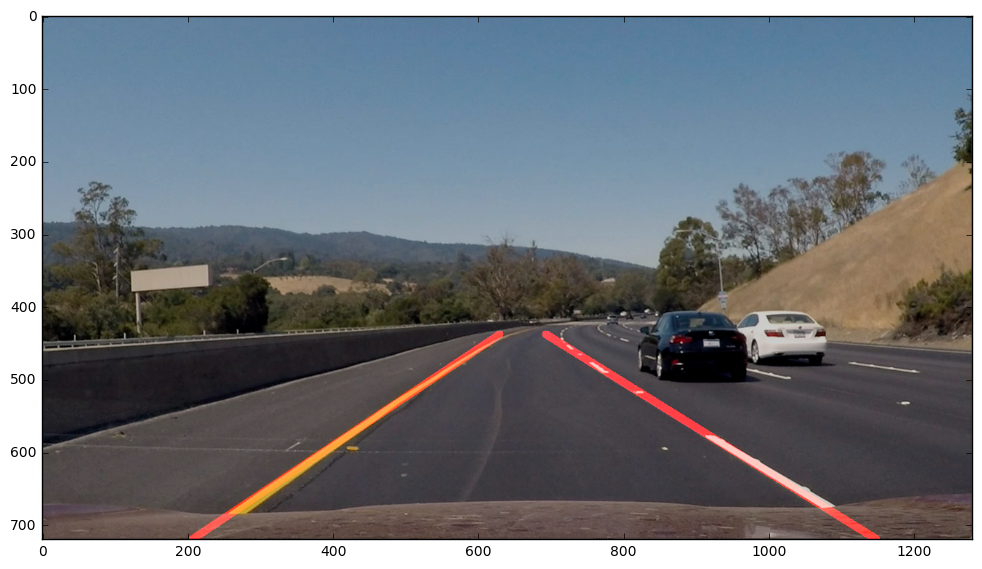

saving snapshot file: solidWhiteCurve-May-25-08-42PM.jpg


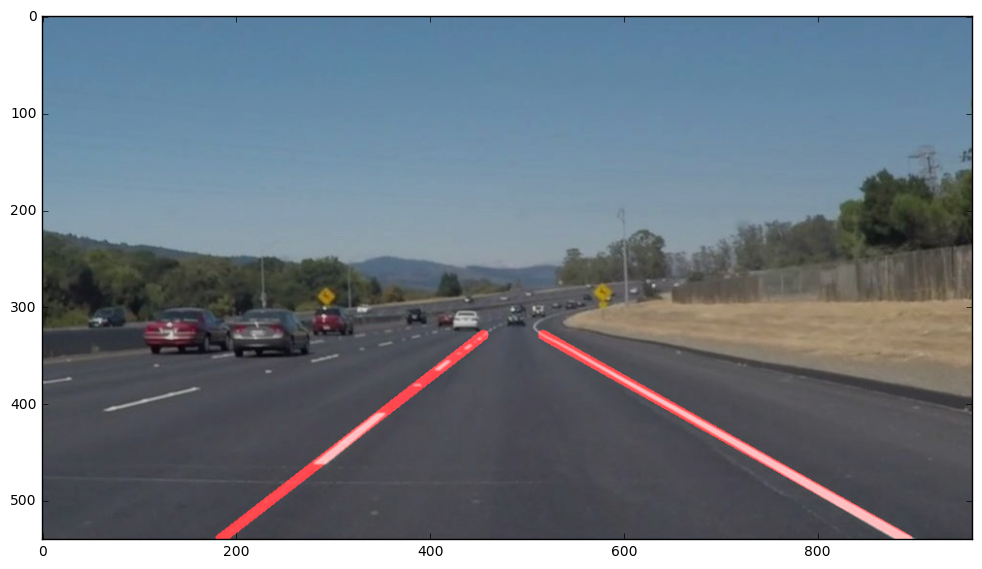

saving snapshot file: solidYellowLeft-May-25-08-42PM.jpg


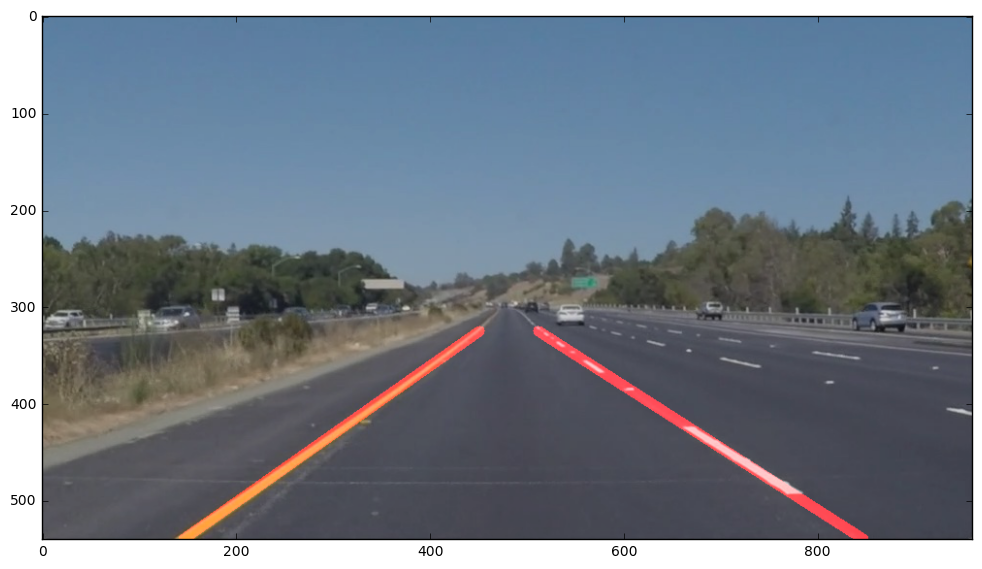

saving snapshot file: challengeShadowFadedLane-May-25-08-42PM.jpg


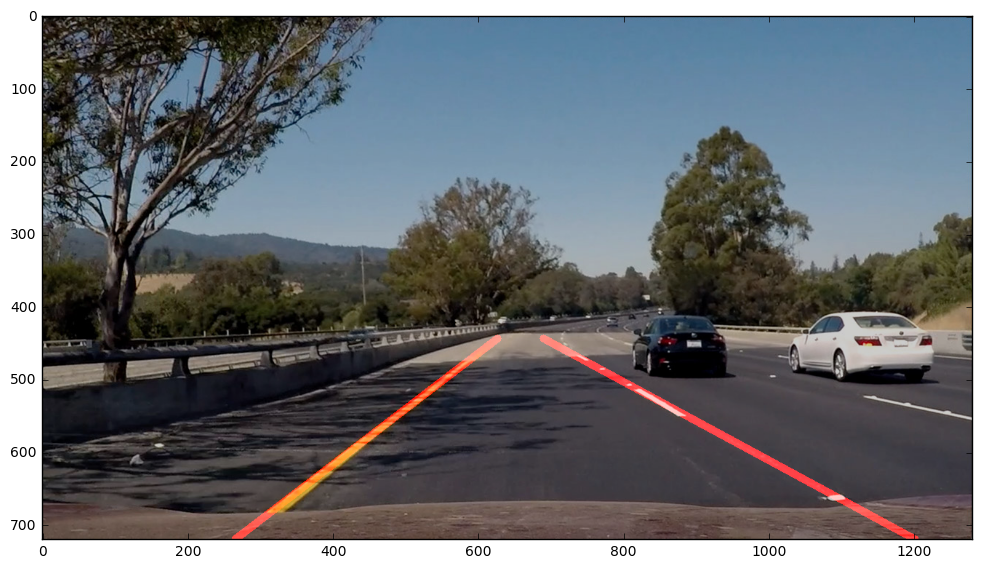

saving snapshot file: challengeRoadColourChange-May-25-08-42PM.jpg


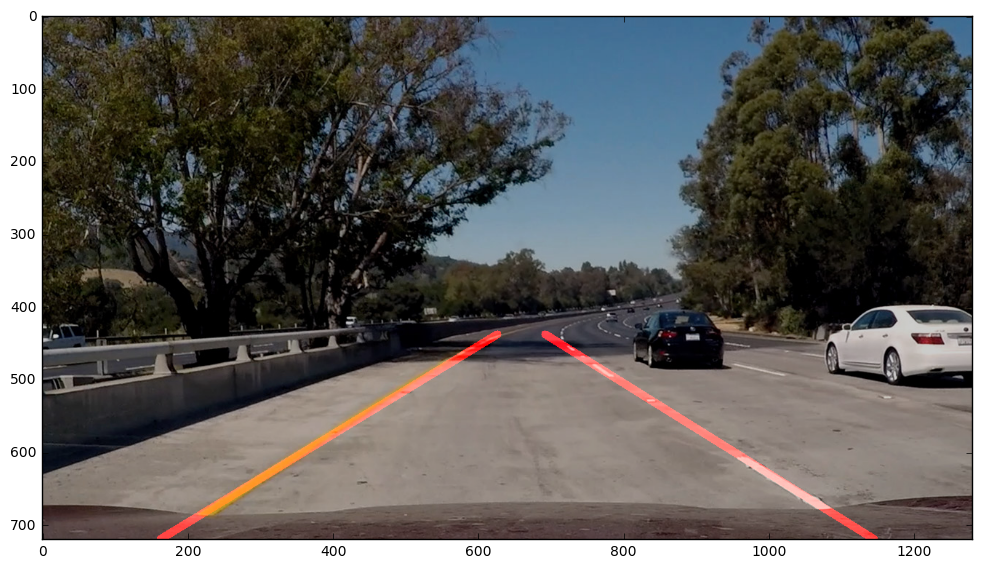

saving snapshot file: whiteCarLaneSwitch-May-25-08-42PM.jpg


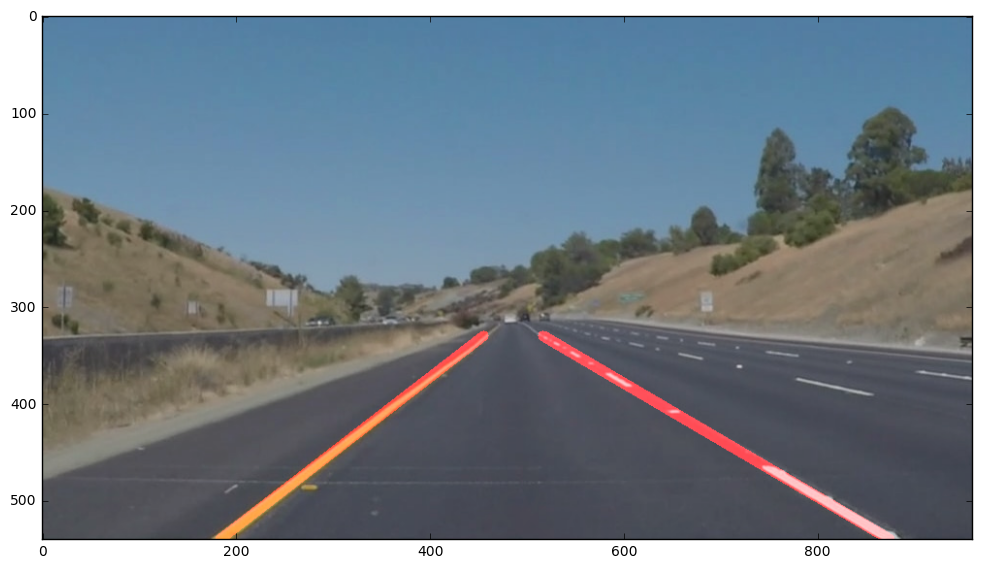

saving snapshot file: solidWhiteRight-May-25-08-42PM.jpg


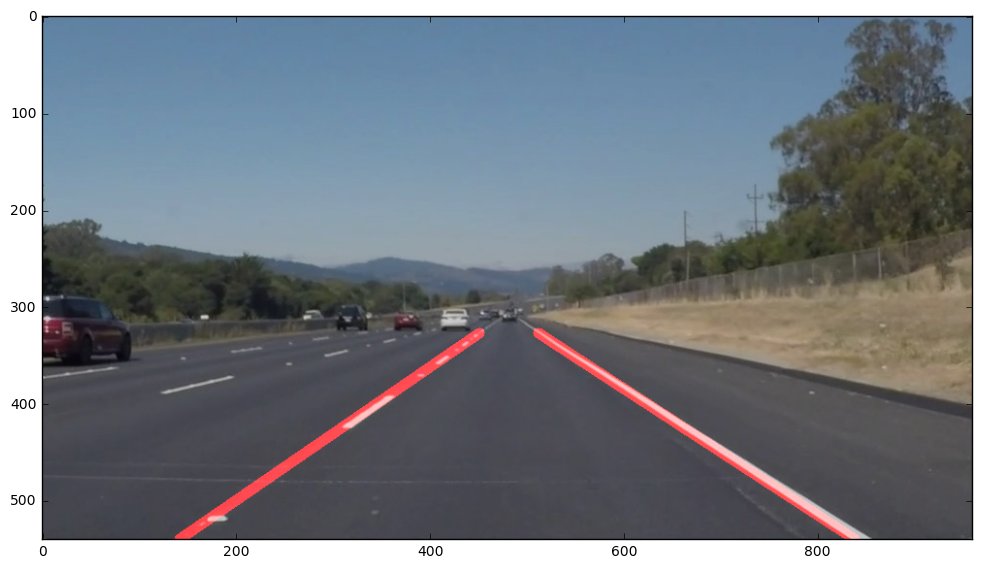

saving snapshot file: solidYellowCurve-May-25-08-42PM.jpg


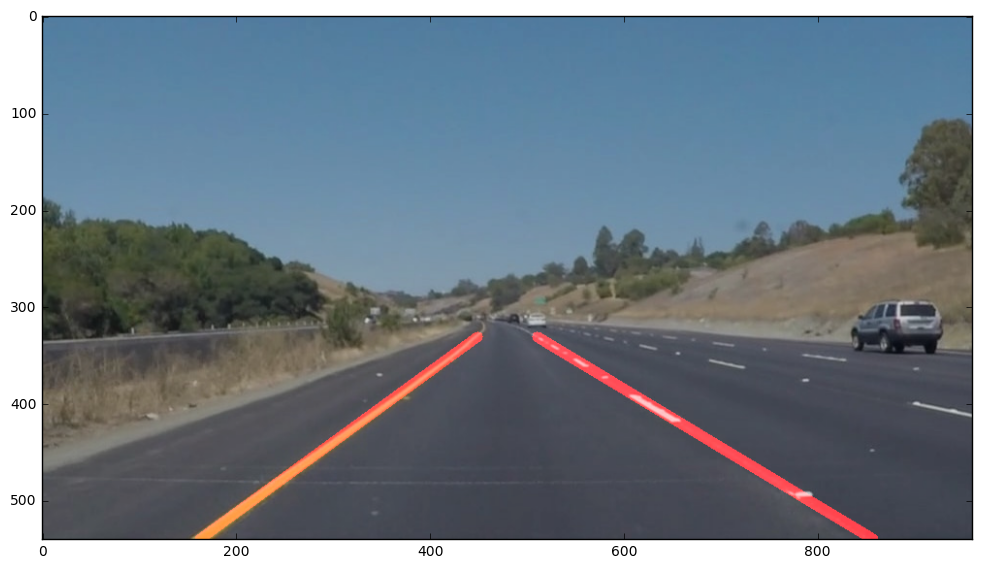

saving snapshot file: challenge.mp4-error-May-23-06-42AM-May-25-08-42PM.jpg


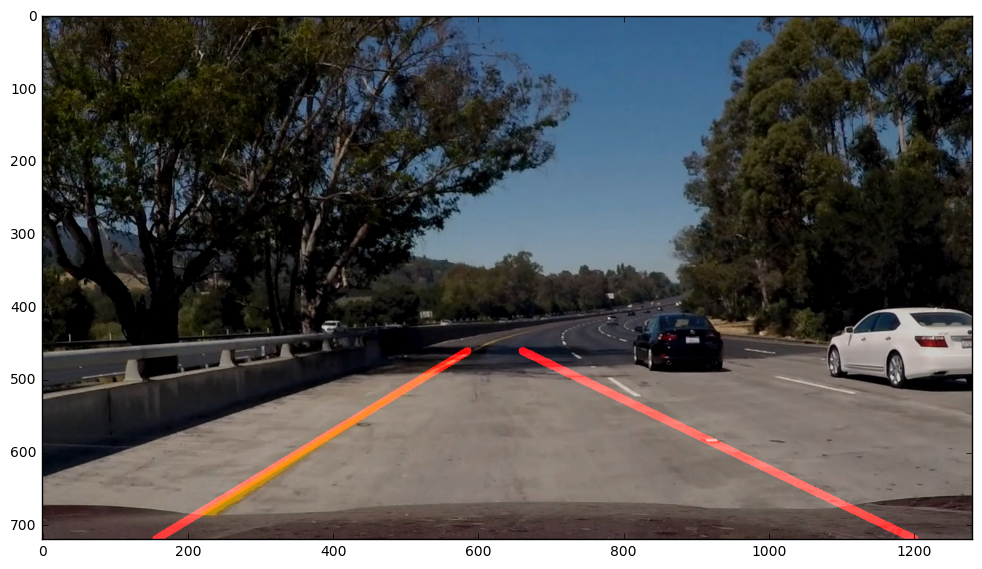

saving snapshot file: solidYellowCurve2-May-25-08-42PM.jpg


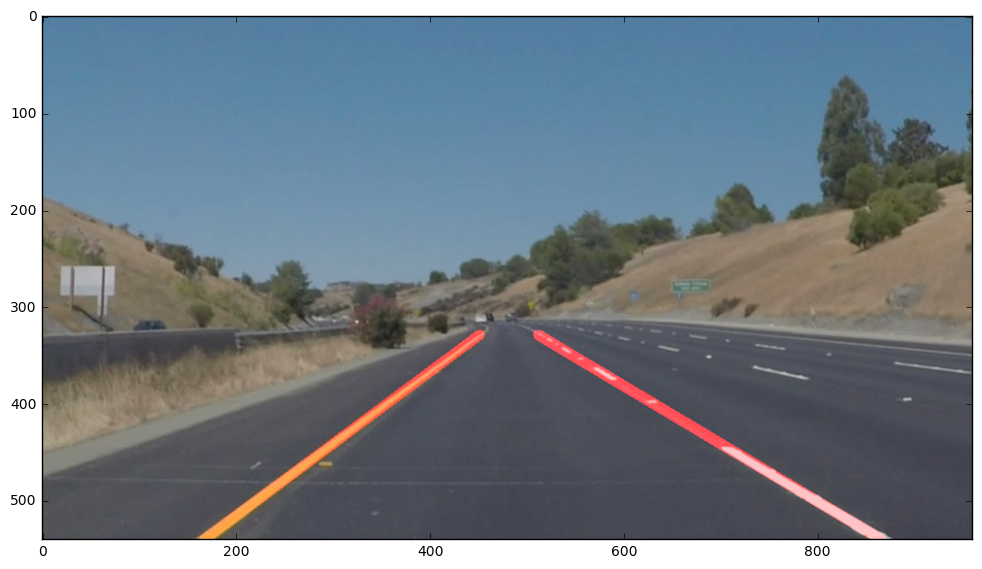

In [17]:
from os import path, listdir
processed_time = datetime.datetime.now().strftime("-%B-%d-%I-%M%p")
image_folder = "test_images/"
out_folder = 'processed_images' 

for file_name in listdir(image_folder):
    if is_image(file_name):          
        plt.figure(figsize=(12, 9))  
        image = mpimg.imread(path.join(image_folder, file_name))
        pipeline = process_image(file_name, out_folder)
        processed_image = pipeline(image)
 
        plt.imshow(processed_image, cmap='gray')
        log_processed_image(processed_image, file_name, processed_time, folder=out_folder)
        plt.show()

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio
imageio.plugins.ffmpeg.download()

Let's try the one with the solid white lane on the right first ...

In [19]:
video_out_folder = 'test_videos_output'
white_output = video_out_folder + '/solidWhiteRight.mp4'
white_input = "test_videos/solidWhiteRight.mp4"
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip(white_input)
white_clip = clip1.fl_image(process_image(white_input, white_output)) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:05<00:00, 38.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 10.5 s, sys: 292 ms, total: 10.8 s
Wall time: 6.19 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [21]:
video_out_folder = 'test_videos_output'
yellow_input = 'test_videos/solidYellowLeft.mp4'
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip(yellow_input)
yellow_clip = clip2.fl_image(process_image(yellow_input, video_out_folder))
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:18<00:00, 35.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 33.3 s, sys: 780 ms, total: 34.1 s
Wall time: 19.3 s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [23]:
video_out_folder = 'test_videos_output'
challenge_output = video_out_folder + '/challenge.mp4'
challenge_input = 'test_videos/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image(challenge_input, video_out_folder))
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


 53%|█████▎    | 133/251 [00:06<00:07, 15.56it/s]

no lanes


100%|██████████| 251/251 [00:12<00:00, 20.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 17.1 s, sys: 612 ms, total: 17.7 s
Wall time: 12.7 s


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))